<a href="https://colab.research.google.com/github/Garric59/DZ_BigData_dash_python/blob/dash/%D0%9A%D0%BE%D0%BF%D0%B8%D1%8F_%D0%B1%D0%BB%D0%BE%D0%BA%D0%BD%D0%BE%D1%82%D0%B0__hw1_boosting_and_explanation_ipynb_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Homework 1

## Gradient boosting on temporal data and feature importances

Here we will work with widely known Human Actividy Recognition (HAR) dataset. Data is available at [UCI repository](https://archive.ics.uci.edu/ml/datasets/human+activity+recognition+using+smartphones).

There are available both raw and preprocessed datasets. This time we will use the preprocessed one.

Today we will work with [LightGBM](https://github.com/Microsoft/LightGBM) by Microsoft. It is one of the most popular frameworks these days that shows both great quality and performance.

There are another great frameworks (listed below). However, we will stick to `LightGBM` for this task.

* [Catboost](https://github.com/catboost/catboost) by Yandex. Novel framework by Yandex company tuned to deal well with categorical features.
* [xgboost](https://github.com/dmlc/xgboost) by dlmc. The most famous framework which got very popular on kaggle.

Some simple preprocessing is done for you. 

Your __ultimate target is to get familiar with one of the frameworks above__ and achieve at least 90% accuracy on test dataset and try to get some useful insights on the features the model paid attention to.

__Please, use [`shap`](https://github.com/slundberg/shap) and interpret the generated plots (with a brief summary).__

_Despite the main language of this notebook is English, feel free to write your thoughts in Russian._

Здесь мы будем работать с широко известным набором данных Human Actividy Recognition (HAR). Данные доступны в репозитории UCI .

Доступны как необработанные, так и предварительно обработанные наборы данных. На этот раз мы воспользуемся препроцессором.

Сегодня мы будем работать с LightGBM от Microsoft. В наши дни это один из самых популярных фреймворков, который показывает отличное качество и производительность.

Есть и другие отличные фреймворки (перечисленные ниже). Однако мы будем придерживаться LightGBMэтой задачи.

Catboost от Яндекс. Новый фреймворк от компании Яндекс настроен на работу с категориальными функциями.
xgboost пользователя dlmc. Самый известный фреймворк, ставший очень популярным на kaggle.
За вас сделана простая предварительная обработка.

Ваша конечная цель - ознакомиться с одной из вышеперечисленных структур и достичь точности не менее 90% на тестовом наборе данных, а также попытаться получить полезную информацию о функциях, на которые модель обращала внимание.

Пожалуйста, используйте shapи интерпретируйте сгенерированные графики (с кратким изложением).

Несмотря на то, что основным языком этой записной книжки является английский, не стесняйтесь писать свои мысли на русском.

## Part 0. Downloading and preprocessing

The preprocessing is done for you. Let's take a look at the data:

In [3]:
# Download and unpack dataset from UCI
!wget -nc https://archive.ics.uci.edu/ml/machine-learning-databases/00240/UCI%20HAR%20Dataset.zip
!unzip -u "UCI HAR Dataset.zip" "UCI HAR Dataset/train/X_train.txt" "UCI HAR Dataset/train/y_train.txt" \
"UCI HAR Dataset/test/X_test.txt" "UCI HAR Dataset/test/y_test.txt" "UCI HAR Dataset/activity_labels.txt"

--2021-11-27 17:26:27--  https://archive.ics.uci.edu/ml/machine-learning-databases/00240/UCI%20HAR%20Dataset.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 60999314 (58M) [application/x-httpd-php]
Saving to: ‘UCI HAR Dataset.zip’

UCI HAR Dataset.zip 100%[===================>]  58.17M  16.1MB/s    in 3.6s    

2021-11-27 17:26:31 (16.1 MB/s) - ‘UCI HAR Dataset.zip’ saved [60999314/60999314]

Archive:  UCI HAR Dataset.zip
  inflating: UCI HAR Dataset/activity_labels.txt  
  inflating: UCI HAR Dataset/test/X_test.txt  
  inflating: UCI HAR Dataset/test/y_test.txt  
  inflating: UCI HAR Dataset/train/X_train.txt  
  inflating: UCI HAR Dataset/train/y_train.txt  


In [4]:
import matplotlib.pyplot as plt
import numpy as np

In [5]:
X_train = np.genfromtxt("UCI HAR Dataset/train/X_train.txt")
y_train = np.genfromtxt("UCI HAR Dataset/train/y_train.txt")
print(f"Train set: {X_train.shape}, {y_train.shape}")

X_test = np.genfromtxt("UCI HAR Dataset/test/X_test.txt")
y_test = np.genfromtxt("UCI HAR Dataset/test/y_test.txt")
print(f"Test set: {X_test.shape}, {y_test.shape}")

n_features = X_train.shape[1]

Train set: (7352, 561), (7352,)
Test set: (2947, 561), (2947,)


In [6]:
activity_labels = {}
with open("UCI HAR Dataset/activity_labels.txt", "r") as file:
    for line in file:
        label, name = line.strip().split(" ")
        activity_labels[int(label)] = name

activity_labels

{1: 'WALKING',
 2: 'WALKING_UPSTAIRS',
 3: 'WALKING_DOWNSTAIRS',
 4: 'SITTING',
 5: 'STANDING',
 6: 'LAYING'}

Let's normalize data

In [7]:
data_mean = X_train.mean(axis=0)
data_std = X_train.std(axis=0)

X_train = (X_train - data_mean) / data_std
X_test = (X_test - data_mean) / data_std

The dataset has some duplicating features. Let's remove them

In [8]:
# fmt: off
duplicating_columns = (
    205, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 231, 244, 257, 507, 520, 533, 546,
)
# fmt: on

duplicating_mask = np.isin(range(n_features), duplicating_columns)

In [9]:
X_train_unique = X_train[:, ~duplicating_mask]
X_test_unique = X_test[:, ~duplicating_mask]

X_train_unique.shape, X_test_unique.shape

((7352, 540), (2947, 540))

PCA could be useful in this case. E.g.

In [10]:
from sklearn.decomposition import PCA

In [11]:
pca = PCA(0.99)

X_train_pca = pca.fit_transform(X_train_unique)
X_test_pca = pca.transform(X_test_unique)

X_train_pca.shape, X_test_pca.shape

((7352, 179), (2947, 179))

Text(0, 0.5, 'Principal component 2')

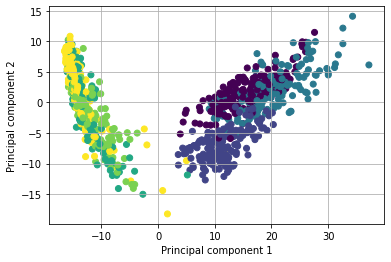

In [12]:
plt.scatter(X_train_pca[:1000, 0], X_train_pca[:1000, 1], c=y_train[:1000])
plt.grid()
plt.xlabel("Principal component 1")
plt.ylabel("Principal component 2")

Text(0, 0.5, 'Principal component 5')

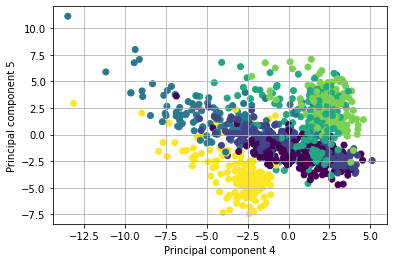

In [13]:
plt.scatter(X_train_pca[:1000, 3], X_train_pca[:1000, 4], c=y_train[:1000])
plt.grid()
plt.xlabel("Principal component 4")
plt.ylabel("Principal component 5")

## Part 1. Fit the model.

Despite optimal parameters (e.g. for xgboost) can be found on the web, we still want you to approximate them by yourself.

In this part just check some (3-5) sets of hyperparameters by hand.

Несмотря на то, что оптимальные параметры (например, для xgboost) можно найти в Интернете, мы все же хотим, чтобы вы приблизили их самостоятельно. В этой части просто проверьте несколько (3-5) наборов гиперпараметров вручную.

In [14]:
# YOUR CODE HERE
from sklearn.metrics import mean_squared_error, f1_score, accuracy_score
from sklearn.model_selection import GridSearchCV

import lightgbm as lgbm

import warnings
warnings.filterwarnings("ignore")

print("Версия LightGBM      : ", lgbm.__version__)
# Example: https://rpubs.com/burakh/har_xgb
from sklearn.model_selection import train_test_split
X, y = X_train_pca, y_train
X_train_train_pca, X_train_val_pca, y_train_train, y_train_val = train_test_split(X, y,
                                                    train_size=0.65, 
                                                    random_state=42,
                                                    stratify=y)

Версия LightGBM      :  2.2.3


In [ ]:
#lgb_train = lgbm.Dataset(X_train_train_pca, y_train_train,free_raw_data=False)
#lgb_eval = lgbm.Dataset(X_train_val_pca, y_train_val, reference=lgb_train,free_raw_data=False)

In [15]:
from numpy import mean
from numpy import std
from lightgbm import LGBMClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from matplotlib import pyplot

In [17]:
# evaluate the model
model = LGBMClassifier()
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)
n_scores = cross_val_score(model, X_train_train_pca, y_train_train, scoring='accuracy', cv=cv, n_jobs=1, error_score='raise')
print('Accuracy: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))
# fit the model on the whole dataset
model = LGBMClassifier()
model.fit(X, y)
# make a single prediction
yhat = model.predict(X_train_val_pca)
print('Prediction: %d' % yhat[0])

Accuracy: 0.951 (0.010)
Prediction: 2


In [ ]:
validation_metrics = {}
param = {
    'boosting_type':'gbdt', 
    'objective':'multiclass',
    'num_class':np.unique(y_train_train).size,
    'metric':'multi_logloss'
}
num_round=10
lgb = lgbm.LGBMClassifier(**param)
lgb.fit(X=X_train_train_pca, y=y_train_train, early_stopping_rounds=10, eval_set=(X_train_val_pca, y_train_val),
    eval_metric='multi_error', verbose=True)
validation_metrics=lgb.evals_result_

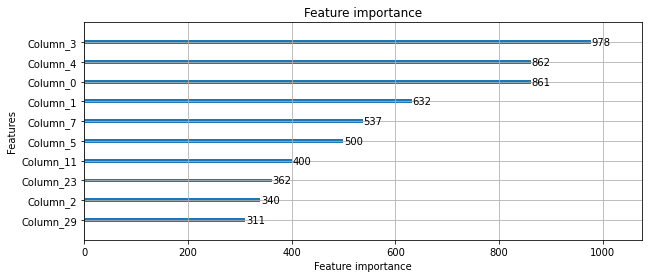

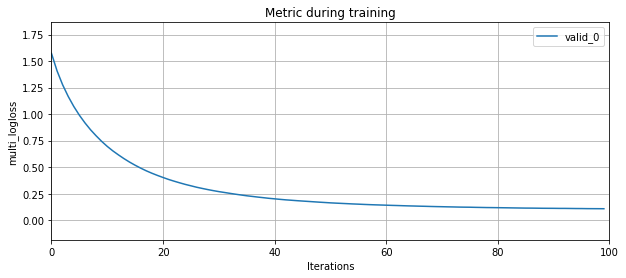

In [57]:
lgbm.plot_importance(lgb, figsize = (10,4),max_num_features=10)
lgbm.plot_metric(validation_metrics, metric='multi_logloss', figsize = (10,4))

In [ ]:
def algorithm_pipeline(X_train_data, X_test_data, y_train_data, y_test_data,
                       model, param_grid, cv=10, scoring_fit='neg_mean_squared_error',
                       do_probabilities = False):
    gs = GridSearchCV(
        estimator=model,
        param_grid=param_grid,
        cv=cv,
        n_jobs=1,
        scoring=scoring_fit,
        verbose=100
    )
    fitted_model = gs.fit(X_train_data, y_train_data)

    if do_probabilities:
        pred = fitted_model.predict_proba(X_test_data)
    else:
        pred = fitted_model.predict(X_test_data)

    return fitted_model, pred

In [ ]:
model = lgbm.LGBMClassifier()

In [ ]:
param_grid = {
    'learning_rate': [0.5, 0.1, 0.01], #скорости обучения
    'objective':['multiclass'],
    'num_class':[np.unique(y_train_train).size],
    'n_estimators': [50, 100, 200], #Количество деревьев
    #'colsample_bytree': [0.7, 0.8], #Соотношение подвыборки столбцов при построении каждого дерева
    'max_depth': [15, 20, 25], #Максимальная глубина дерева
    'num_leaves': [50, 100, 200], #Максимальное количество листьев дерева
    #'reg_alpha': [1.1, 1.2, 1.3], #регуляризации L1 по весам
    #'reg_lambda': [1.1, 1.2, 1.3] #регуляризации L2 по весам
    #'min_split_gain': [0.3, 0.4], #Минимальное снижение потерь
    #'subsample': [0.7, 0.8, 0.9], #Отношение подвыборки
    #'subsample_freq': [20], #Частота подвыборки
    'random_state':[42]
}

model, pred = algorithm_pipeline(X_train_train_pca, X_train_val_pca, y_train_train, y_train_val, model,
                                 param_grid, cv=5, scoring_fit='accuracy')



In [ ]:
print("\nBest Accuracy: %f"%model.best_score_)
print(model.best_params_)

In [ ]:
validation_metrics_2={}
lgb = lgbm.train(params={'learning_rate': 0.1, 'max_depth': 20, 'n_estimators': 200, 'num_class': 7, 'num_leaves': 50, 'objective': 'multiclass', 'random_state': 42}, train_set=lgb_train, valid_sets=lgb_eval,early_stopping_rounds=5,verbose_eval=10,evals_result=validation_metrics_2)

In [ ]:
#pred = lgb.predict(X_train_val_pca)

In [ ]:
lgbm.plot_importance(lgb, figsize = (10,4),max_num_features=10)
lgbm.plot_split_value_histogram(lgb, feature = 'Column_3', figsize = (10,4))
lgbm.plot_metric(validation_metrics_2, metric='multi_logloss', figsize = (10,4))

## Part 2. Use hyper parameter tuning system

Use [optuna](https://optuna.org/), [hyperopt](http://hyperopt.github.io/hyperopt/) or any other zero order optimizer to find optimal hyper param set.

In [62]:
# YOUR CODE HERE
!pip install optuna
import optuna
#import lightgbm as lgb_new
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import log_loss

     |████████████████████████████████| 308 kB 4.2 MB/s 
     |████████████████████████████████| 209 kB 41.9 MB/s 
     |████████████████████████████████| 80 kB 8.6 MB/s 
     |████████████████████████████████| 75 kB 4.3 MB/s 
     |████████████████████████████████| 49 kB 5.3 MB/s 
     |████████████████████████████████| 112 kB 62.1 MB/s 
     |████████████████████████████████| 149 kB 68.9 MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11136 sha256=b9b58edcf26c2cb5d3c06ebc815c072331c2251c21e9570fb03e4affd80de915
  Stored in directory: /root/.cache/pip/wheels/9f/18/84/8f69f8b08169c7bae2dde6bd7daf0c19fca8c8e500ee620a28
Successfully built pyperclip


In [64]:
def objective(trial):
    param = {
        "objective": "multiclass",
        "num_class":6,
        "metric": "multi_logloss",
        "verbosity": 10,
        #"boosting_type": "gbdt",
        "force_col_wise":True,
        "num_leaves": trial.suggest_int("num_leaves", 2, 256),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.4, 1.0),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.4, 1.0),
        "bagging_freq": trial.suggest_int("bagging_freq", 1, 7),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
    }

    # Add a callback for pruning.
    pruning_callback = optuna.integration.LightGBMPruningCallback(trial, "multi_logloss")
    gbm = lgb.fit(param, train_sets=(X_train_train_pca, y_train_train), valid_sets= (X_train_val_pca, y_train_val), callbacks=[pruning_callback])

    preds = gbm.predict(X_train_val_pca)
    pred_labels = np.rint(preds)
    accuracy = accuracy_score(lgb_eval, pred_labels)
    return accuracy


if __name__ == "__main__":
    study = optuna.create_study(
        pruner=optuna.pruners.MedianPruner(n_warmup_steps=10), direction="minimize"
    )
    study.optimize(objective, n_trials=10, show_progress_bar=True)

    print("Number of finished trials: {}".format(len(study.trials)))

    print("Best trial:")
    trial = study.best_trial

    print("  Value: {}".format(trial.value))

    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))

[I 2021-11-27 18:51:01,713] A new study created in memory with name: no-name-ae58e441-a739-4e13-b663-6979278a8a0f


  0%|          | 0/10 [00:00<?, ?it/s]

[W 2021-11-27 18:51:01,759] Trial 0 failed because of the following error: TypeError("fit() got an unexpected keyword argument 'train_sets'")
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/optuna/study/_optimize.py", line 213, in _run_trial
    value_or_values = func(trial)
  File "<ipython-input-64-4a5692eba6dd>", line 18, in objective
    gbm = lgb.fit(param, train_sets=(X_train_train_pca, y_train_train), valid_sets= (X_train_val_pca, y_train_val), callbacks=[pruning_callback])
TypeError: fit() got an unexpected keyword argument 'train_sets'


TypeError: ignored

### Conclusion

Please, write down your thoughts on the experiment results:

...

## Part 3. Interpret the model predictions

Please use [shap](https://github.com/slundberg/shap) to build some plots and try to interpret them.

In [ ]:
import shap  # noqa: F401
X_train_train_pca, y_train_train

# YOUR CODE HERE
params = {
    "max_bin": 512,
    "learning_rate": 0.05,
    "boosting_type": "gbdt",
    "objective": "multiclass",
    "num_class":np.unique(y_train_train).size,
    "metric": "multi_error",
    "num_leaves": 10,
    "verbose": -1,
    "min_data": 100,
    "boost_from_average": True
}

model = lgb.fit(params, X_train_train_pca, 10000, eval_set=[y_train_val], early_stopping_rounds=50)

In [ ]:
y_train_val.astype(int)

### Conclusion

Your thoughts about the plots and model behaviour:

...